# Visualise GRACE data:

In [1]:
# from grace.evaluation.annotation import display_image_and_grace_annotation
from grace.evaluation.visualisation import (
    display_image_and_grace_annotation, 
    read_patch_stack_by_label, 
    montage_from_image_patches, 
    overlay_from_image_patches,
)
from grace.io import read_graph


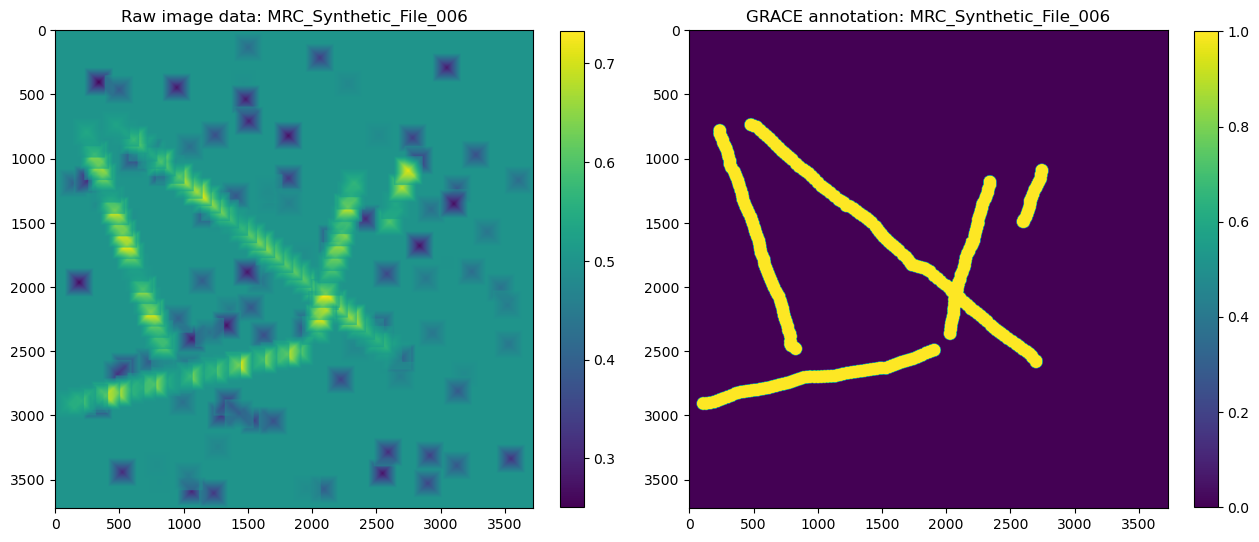

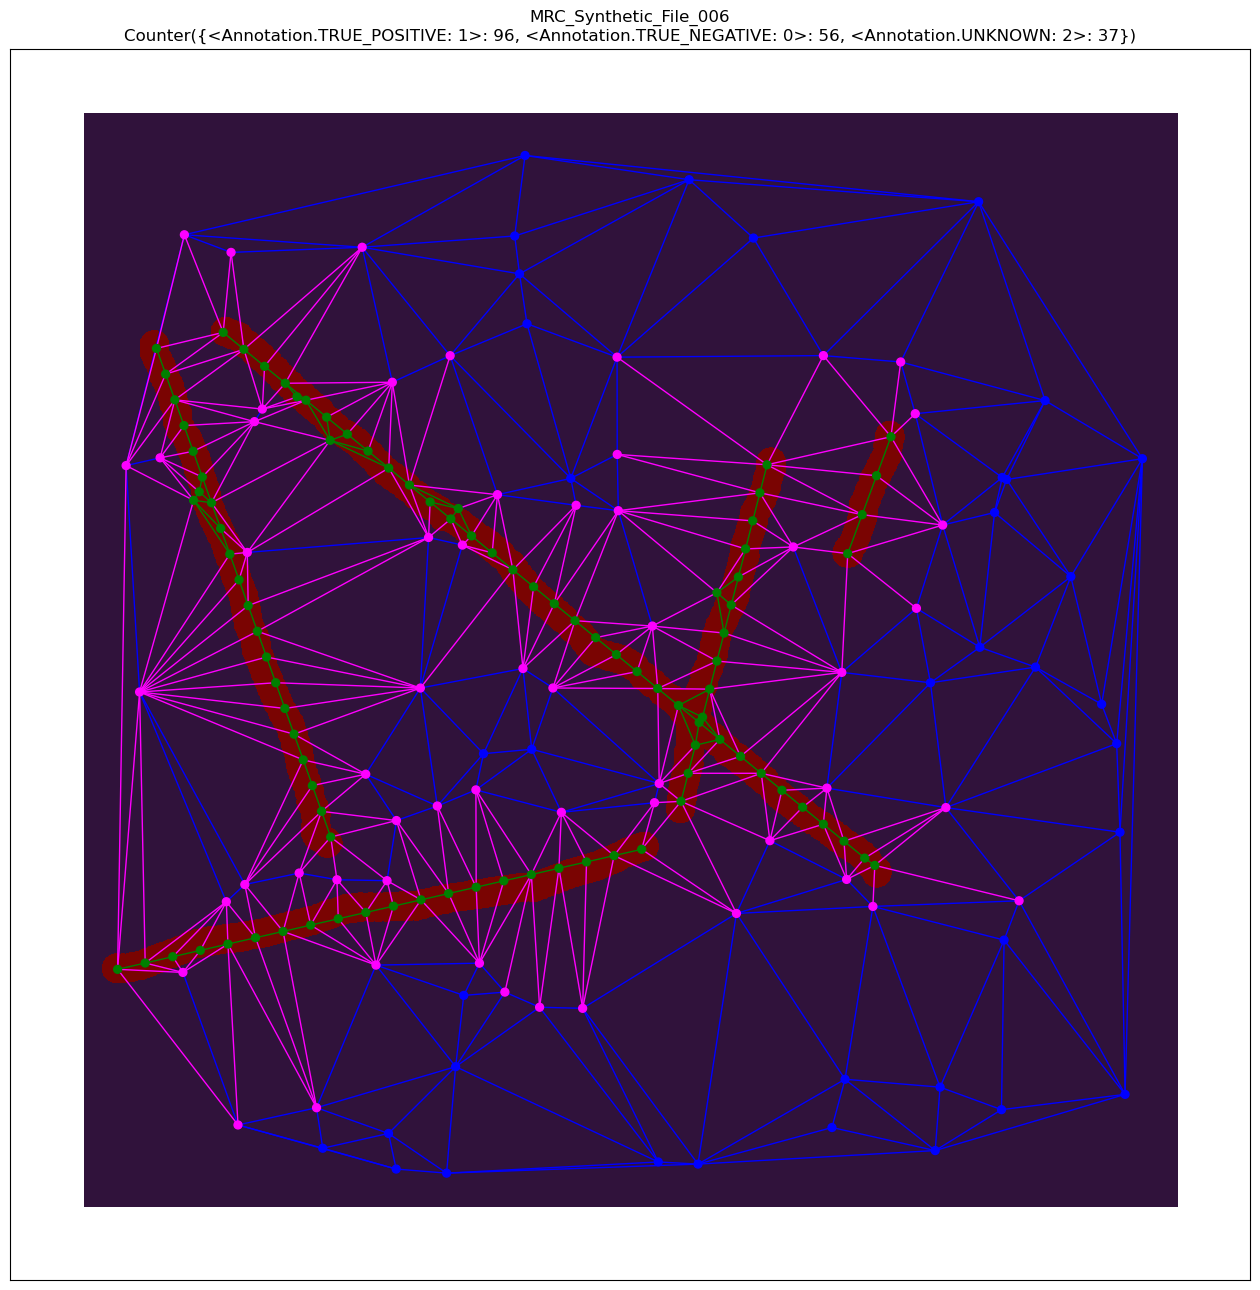

In [2]:
path = "/Users/kulicna/Desktop/dataset/shape_stars/infer/MRC_Synthetic_File_006.grace"

display_image_and_grace_annotation(grace_annotation_path=path)

# Montages:

In [3]:
from pathlib import Path
import mrcfile


In [4]:
dataset = read_graph(Path(path))
raw_image_path = path.replace(".grace", ".mrc")
mrc_image = mrcfile.open(raw_image_path, "r").data
graph = dataset.graph


In [5]:
something = read_patch_stack_by_label(
    graph, 
    mrc_image, 
    crop_shape=(224, 224),
)

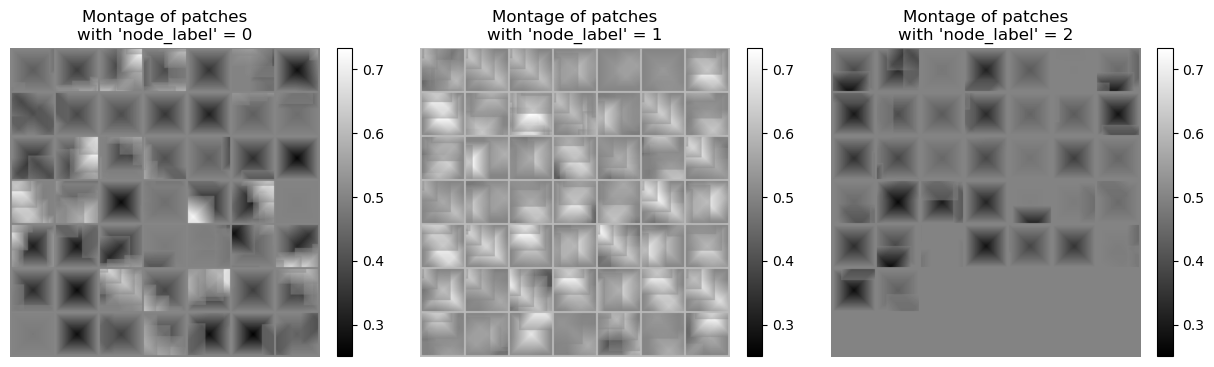

In [6]:
montage_from_image_patches(something)

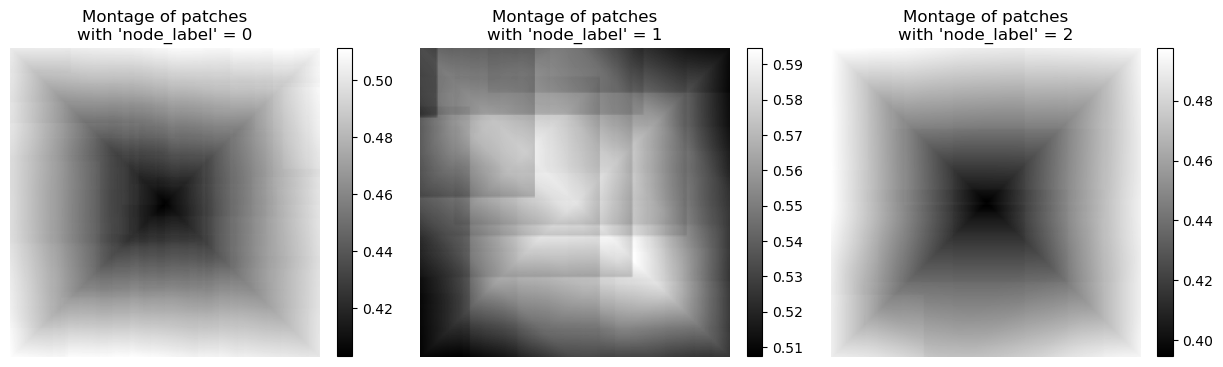

In [7]:
overlay_from_image_patches(something)

# read grace files

In [10]:
from grace.base import GraphAttrs
from grace.io import read_graph
from grace.napari.utils import EdgeColor
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [43]:
path = "/Users/kulicna/Desktop/dataset/shape_stars/infer/MRC_Synthetic_File_006.grace"
# path = "/Users/kulicna/Desktop/dataset/shape_stars/train/MRC_Synthetic_File_000.grace"

dataset = read_graph(Path(path))

In [44]:
dataset.metadata

{'image_filename': 'MRC_Synthetic_File_006'}

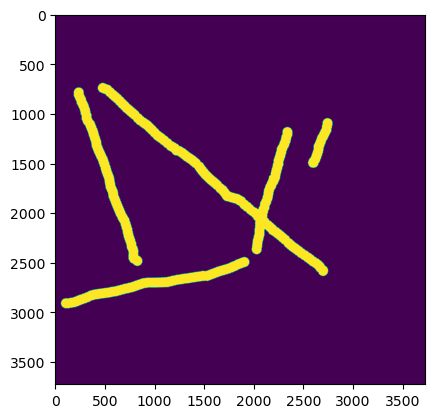

In [45]:
plt.imshow(dataset.annotation)

In [46]:
graph = dataset.graph

In [47]:
graph

In [53]:
counter = [0] * 3

for idx, node in graph.nodes(data=True):
    counter[node[GraphAttrs.NODE_GROUND_TRUTH]] += 1

counter

[56, 96, 37]

In [48]:
graph.nodes(data=True)[0]

{<GraphAttrs.NODE_X: 'x'>: 1062.1717529296875,
 <GraphAttrs.NODE_Y: 'y'>: 3594.8076171875,
 <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan,
 <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.UNKNOWN: 2>,
 <GraphAttrs.NODE_FEATURES: 'features'>: None}

Text(0.5, 1.0, 'MRC_Synthetic_File_006')

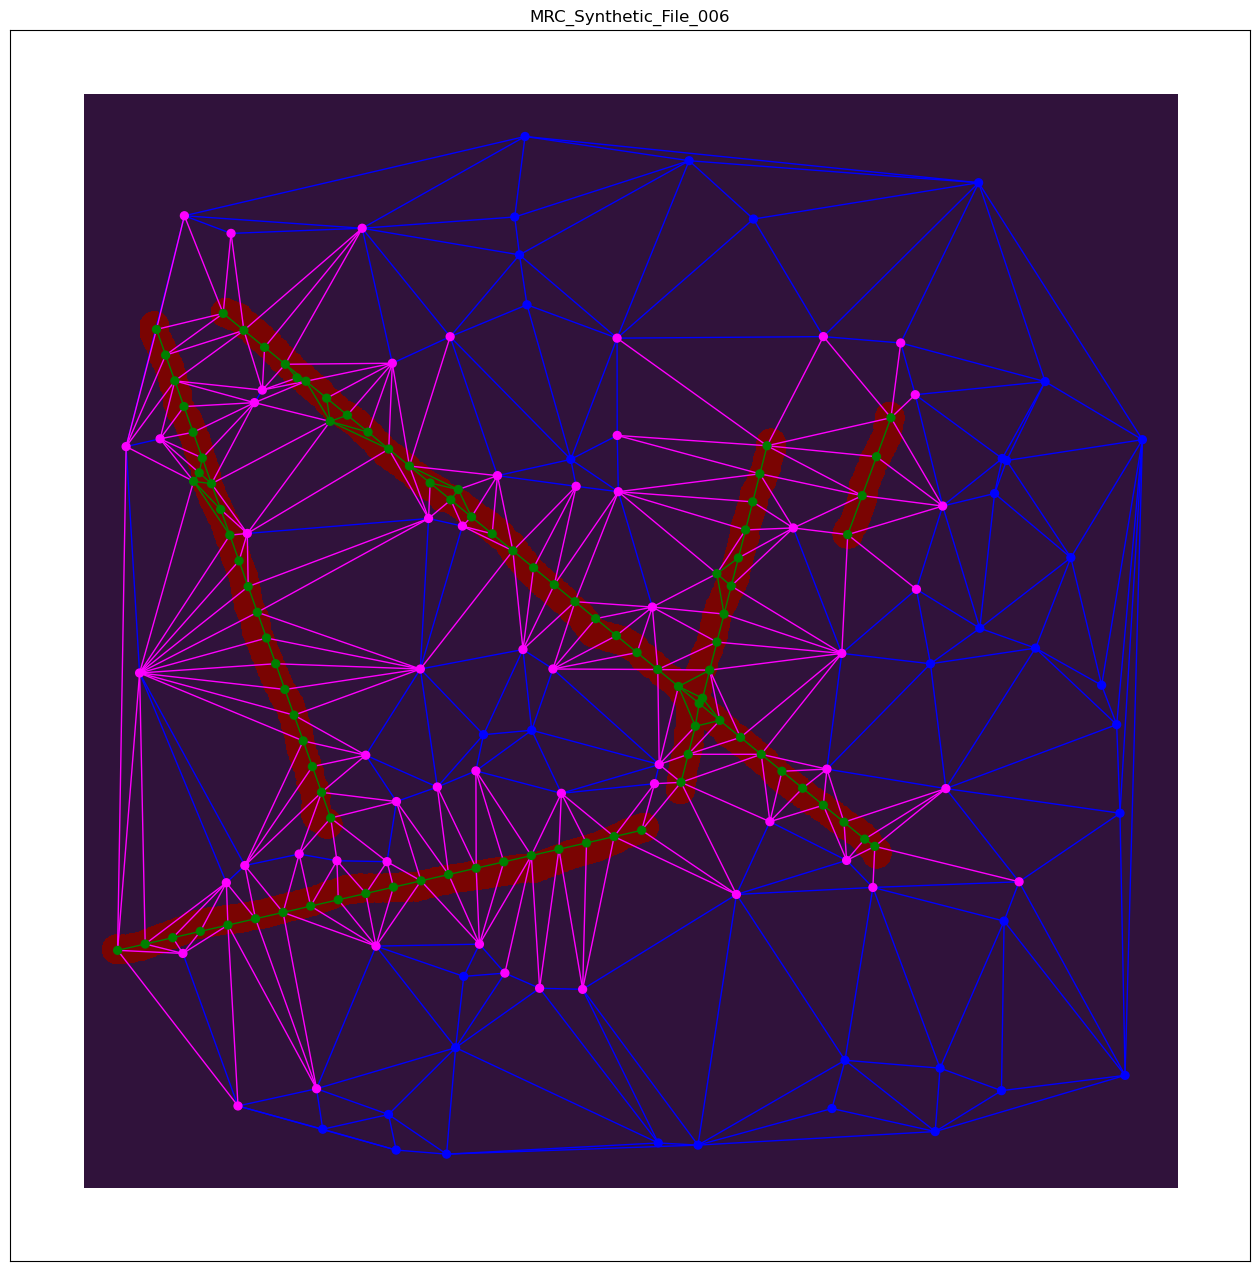

In [49]:

fig, ax = plt.subplots(figsize=(16, 16))

# node positions
pos = {
    idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) 
    for idx, node in graph.nodes(data=True)
}
# edge annotations
edge_gt = [graph[u][v][GraphAttrs.EDGE_GROUND_TRUTH] for u, v in graph.edges]
edge_colors = [EdgeColor[gt.name].value for gt in edge_gt]

node_colors = [
    EdgeColor[node_attrs[GraphAttrs.NODE_GROUND_TRUTH].name].value 
    for _, node_attrs in graph.nodes(data=True)
]

ax.imshow(dataset.annotation, cmap=plt.cm.turbo, interpolation="none")

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(
    dataset.graph, 
    ax=ax, 
    pos=pos, 
    with_labels=False, 
    # node_color="w", 
    node_size=32,
    edge_color=edge_colors,
    node_color=node_colors,
)

ax.set_title(dataset.metadata["image_filename"])

In [42]:
np.unique(dataset.annotation)

array([0, 1])

In [34]:
dataset

GraceFileDataset(metadata={'image_filename': 'MRC_Synthetic_File_008'}, graph=<networkx.classes.graph.Graph object at 0x7ff774100820>, annotation=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]))

In [73]:
path

'/Users/kulicna/Desktop/dataset/shape_stars/infer/MRC_Synthetic_File_006.grace'

In [74]:
img = path.replace(".grace", ".mrc")

import mrcfile

with mrcfile.open(img, "r") as mrc:
    # image_data = mrc.data.astype(int)
    image_data = mrc.data

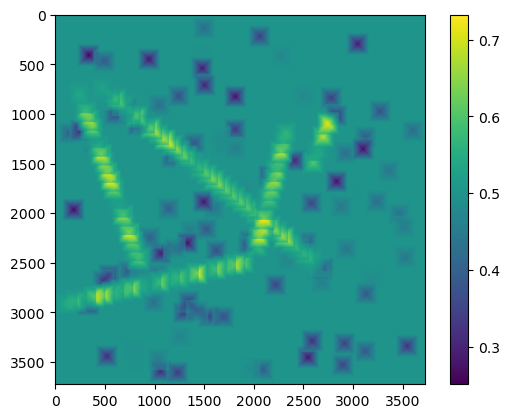

In [77]:
plt.imshow(image_data)
plt.colorbar()
plt.show()

In [3]:
import numpy.typing as npt

from grace.base import GraphAttrs, Annotation
from skimage.util import montage


In [6]:
Annotation.keys

AttributeError: keys

In [81]:
def montage_from_image(
    G: nx.Graph, image: npt.NDArray, crop_shape: tuple[int, int]
) -> None:
    """Visualise the montages of some true negative (0) and true positive (1) nodes.

    Parameters
    ----------
    G : nx.Graph
        A (synthetic) networkx graph.
    image : np.array
        Simulated image corresponding to the graph.
    crop_shape : tuple[int, int]
        Shape of the cropped patches to train on
        (e.g. (224, 224) - compatible to resnet input).
    """

    plt.figure(figsize=(10, 5))
    crops = [[], []]

    for _, node in G.nodes.data():
        coords = node[GraphAttrs.NODE_Y], node[GraphAttrs.NODE_X]
        st_x, en_x = (
            int(coords[0]) - crop_shape[0] // 2,
            int(coords[0]) + crop_shape[0] // 2,
        )
        st_y, en_y = (
            int(coords[1]) - crop_shape[1] // 2,
            int(coords[1]) + crop_shape[1] // 2,
        )

        # Sort crops based on labels:
        # crop = image[st_x:en_x, st_y:en_y].numpy()
        crop = image[st_x:en_x, st_y:en_y]
        label = node[GraphAttrs.NODE_GROUND_TRUTH]
        if label < Annotation.UNKNOWN:
            crops[label].append(crop)

    print ([len(c) for c in crops])
    for c, crop_collection in enumerate(crops):
        mont = montage(
            # TODO: Randomise
            crop_collection[:49],
            grid_shape=(7, 7),
            padding_width=10,
            fill=np.max([np.max(c) for c in crop_collection[0]]),
        )
        # TODO: Remember the very mn & mx across both stacks
        print (c, np.min(mont), np.max(mont))
        plt.subplot(1, 2, c + 1)
        plt.imshow(mont, cmap="binary_r", vmin=np.min(mont), vmax=np.max(mont))
        plt.colorbar(fraction=0.045)
        plt.title(f"Montage of patches\nwith 'node_label' = {c}")
        plt.axis("off")
    plt.show()
    plt.close()

    # TODO: return the image stack for all classes 


[56, 96]
0 0.2508105 0.6785696
1 0.40319186 0.73244244


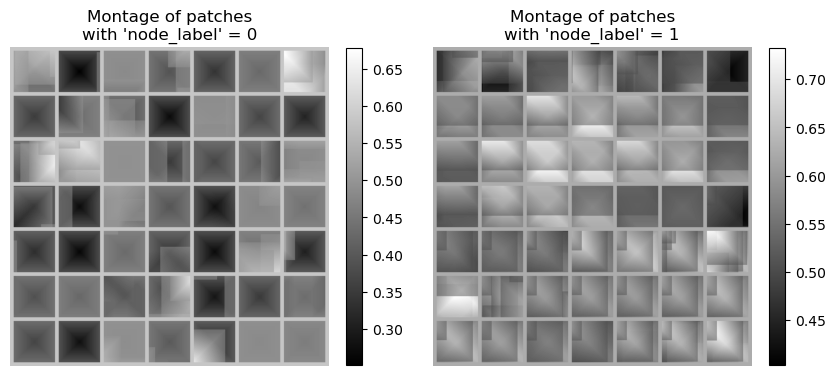

In [82]:
# from grace.simulator.simulate_image import montage_from_image

montage_from_image(
    G=graph,
    image=image_data,
    crop_shape=(112, 112)
)

In [8]:
import torch

/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
t = torch.Tensor([1, 1, 1, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 1, 2, 2, 0, 0, 1,
        0, 2, 2, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 2, 2, 0, 0, 0, 2])

In [11]:
t.shape, t.dtype

(torch.Size([48]), torch.float32)

In [12]:
2 in t

True

In [13]:
from sklearn.metrics import confusion_matrix

In [15]:
y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
confusion_matrix(y_true, y_pred, labels=["ant", "cat"])
# array([[2, 0, 0],
#        [0, 0, 1],
#        [1, 0, 2]])


array([[2, 0],
       [1, 2]])